In [39]:
!pip install matplotlib seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [47]:
# 반드시 노트북 맨 위 셀에서 한 번 실행
%matplotlib inline

In [40]:
import sys

sys.path.append("/app")

from src.utils.spark_builder import get_spark_session
from pyspark.sql import functions as F

# Spark 세션 생성
spark = get_spark_session("GDELT_SilverEDA_Test", "spark://spark-master:7077")
print("✅ Spark 세션 생성 완료")

✅ Spark 세션 생성 완료


In [41]:
# Parquet 파일 로드
silver_path = "s3a://warehouse/silver/gdelt_events/"
df = spark.read.parquet(silver_path)

print("✅ 데이터 로드 완료")
print(f"총 레코드 수: {df.count()}")
print(f"컬럼 수: {len(df.columns)}")

✅ 데이터 로드 완료


총 레코드 수: 4177
컬럼 수: 63


In [42]:
df.printSchema()
df.show(5, truncate=False)

root
 |-- global_event_id: long (nullable = true)
 |-- day: integer (nullable = true)
 |-- month_year: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- fraction_date: double (nullable = true)
 |-- actor1_code: string (nullable = true)
 |-- actor1_name: string (nullable = true)
 |-- actor1_country_code: string (nullable = true)
 |-- actor1_known_group_code: string (nullable = true)
 |-- actor1_ethnic_code: string (nullable = true)
 |-- actor1_religion1_code: string (nullable = true)
 |-- actor1_religion2_code: string (nullable = true)
 |-- actor1_type1_code: string (nullable = true)
 |-- actor1_type2_code: string (nullable = true)
 |-- actor1_type3_code: string (nullable = true)
 |-- actor2_code: string (nullable = true)
 |-- actor2_name: string (nullable = true)
 |-- actor2_country_code: string (nullable = true)
 |-- actor2_known_group_code: string (nullable = true)
 |-- actor2_ethnic_code: string (nullable = true)
 |-- actor2_religion1_code: string (nullable = true)

<h3> 1) 결측치 계산 </h3>

In [43]:
# 결측치
from pyspark.sql import functions as F

total = df.count()
null_stats = df.select(
    [(F.count(F.when(F.col(c).isNull(), c)) / total).alias(c) for c in df.columns]
)
null_stats.show(truncate=False)

+---------------+---+----------+----+-------------+-------------------+-------------------+-------------------+-----------------------+------------------+---------------------+---------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+-----------------------+------------------+---------------------+---------------------+------------------+-----------------+-----------------+-------------+----------+---------------+---------------+----------+---------------+------------+-----------+------------+--------+---------------+-------------------+-----------------------+--------------------+------------------+-------------------+---------------------+-------------------+-------------------+-----------------------+--------------------+--------------+------------------+---------------------+-------------------+-------------------+-----------------------+--------------------+--------------+---------------+----------------

In [44]:
null_pdf = null_stats.toPandas().T.reset_index()
null_pdf.columns = ["column", "null_ratio"]
null_pdf = null_pdf.sort_values("null_ratio", ascending=False)

null_pdf.head(20)

,column,null_ratio
14,actor1_type3_code,1.000000
24,actor2_type3_code,1.000000
58,actor1_geo_centroid,1.000000
60,action_geo_centroid,1.000000
54,action_geo_long,1.000000
59,actor2_geo_centroid,1.000000
46,actor2_geo_lat,1.000000
53,action_geo_lat,1.000000
11,actor1_religion2_code,0.998803
21,actor2_religion2_code,0.998803


1-2) 결측치 비율 요약

| 컬럼 그룹/예시                                                                                                         | 결측률           | 비고                  |
| ---------------------------------------------------------------------------------------------------------------- | ------------- | ------------------- |
| `global_event_id`, `day`, `year`, `num_articles`, `goldstein_scale`, `avg_tone`, `processed_time`, `source_file` | 0.0           | 전부 존재, 핵심 컬럼 ✅      |
| `actor1_country_code`                                                                                            | \~0.45        | 절반 정도 결측, 보조 변수     |
| `actor2_country_code`                                                                                            | \~0.55        | 절반 이상 결측, 보조 변수     |
| `actor*_known_group_code`, `actor*_ethnic_code`, `actor*_religion*`                                              | 0.9+          | 대부분 결측 → 제외 후보      |
| `actor*_geo_lat/long`                                                                                            | 0.5\~0.6      | 절반 이상 결측, 보조 변수     |
| `action_geo_lat/long`                                                                                            | \~0.35        | 일부 결측, 주요 분석에 활용 가능 |
| `actor*_geo_fullname`, `action_geo_fullname`                                                                     | 다양 (0.3\~0.7) | 지리정보, 부분 결측 있음      |
| `date_added`, `source_url`                                                                                       | 0.0           | 메타정보, 전부 존재         |


1-3) Silver 테이블 결측치 요약 
✅ 핵심 (결측 없음, 반드시 유지)

| 컬럼명                    |
| ---------------------- |
| global\_event\_id      |
| day, year, month\_year |
| num\_articles          |
| goldstein\_scale       |
| avg\_tone              |
| processed\_time        |
| source\_file           |
| date\_added            |
| source\_url            |

📌 보조 (부분 결측 있음, 상황 따라 활용)
| 컬럼명                                  | 결측률(대략)  | 비고           |
| ------------------------------------ | -------- | ------------ |
| actor1\_country\_code                | \~0.45   | 국가 정보, 절반 존재 |
| actor2\_country\_code                | \~0.55   | 국가 정보, 절반 존재 |
| action\_geo\_lat / action\_geo\_long | \~0.35   | 행동 지점 좌표     |
| actor1\_geo\_lat / actor1\_geo\_long | \~0.55   | 행위자1 좌표      |
| actor2\_geo\_lat / actor2\_geo\_long | \~0.65   | 행위자2 좌표      |
| actor\*\_geo\_fullname               | 0.3\~0.7 | 지명 문자열       |
| action\_geo\_fullname                | \~0.35   | 행동 지점명       |

🚫 제외 후보 (거의 전부 결측)
| 컬럼명                                        | 결측률  | 비고    |
| ------------------------------------------ | ---- | ----- |
| actor\*\_known\_group\_code                | 0.9+ | 그룹 코드 |
| actor\*\_ethnic\_code                      | 0.9+ | 민족 코드 |
| actor\*\_religion1\_code / religion2\_code | 0.9+ | 종교 코드 |
| actor\*\_type2\_code / type3\_code         | 0.9+ | 세부 타입 |


2) 수치형 컬럼 기본 통계

In [ ]:
num_cols = [
    c
    for (c, t) in df.dtypes
    if t in ("int", "bigint", "double", "float", "long", "decimal")
]
df.select(*num_cols).describe().show()

+-------+--------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+------------------+--------------+-----------------+--------------+---------------+
|summary|     global_event_id|                day|        month_year|               year|      fraction_date|     is_root_event|        quad_class|   goldstein_scale|     num_mentions|       num_sources|     num_articles|           avg_tone|    actor1_geo_lat|   actor1_geo_long|actor2_geo_lat|  actor2_geo_long|action_geo_lat|action_geo_long|
+-------+--------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+------------------+--------------+-----------------+

3) 시계열 집계 (event_date 파생)

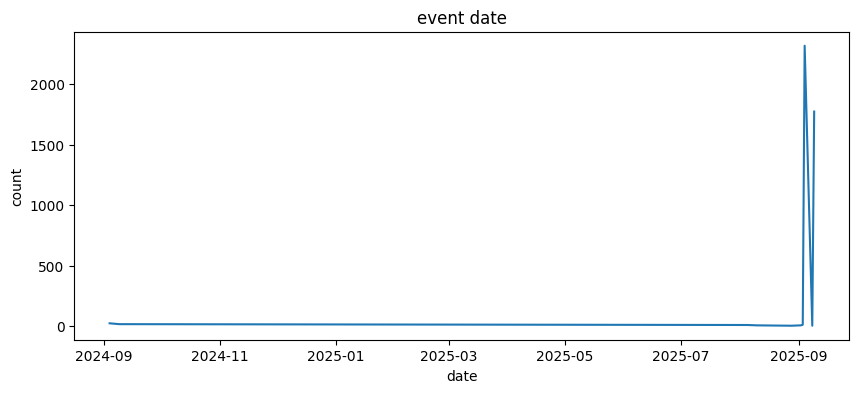

In [ ]:
# day → event_date 변환
# 프로젝트 시작 일자부터 집계된 상태

if "event_date" not in df.columns and "day" in df.columns:
    df = df.withColumn("event_date", F.to_date(F.col("day").cast("string"), "yyyyMMdd"))

# 일별 이벤트 수
ts_agg = (
    df.groupBy("event_date").agg(F.count("*").alias("events")).orderBy("event_date")
)
ts_pdf = ts_agg.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(ts_pdf["event_date"], ts_pdf["events"])
plt.title("event date")
plt.xlabel("date")
plt.ylabel("count")
plt.show()

4) 매핑 오류 

In [51]:
from pyspark.sql import functions as F

# 나라코드 알파벳(2~3자) vs 숫자 여부 카운트
df.select(
    F.sum(
        F.when(F.col("action_geo_country_code").rlike("^[A-Z]{2,3}$"), 1).otherwise(0)
    ).alias("alpha_code"),
    F.sum(
        F.when(F.col("action_geo_country_code").rlike("^[0-9]+$"), 1).otherwise(0)
    ).alias("numeric_value"),
    F.count("*").alias("rows"),
).show()

# 숫자로 들어간 행에서 action_geo_type과의 매핑 확인 (숫자가 사실 type인지 검증)
(
    df.filter(F.col("action_geo_country_code").rlike("^[0-9]+$"))
    .groupBy("action_geo_country_code", "action_geo_type")
    .count()
    .orderBy(F.desc("count"))
    .show(10, truncate=False)
)

+----------+-------------+----+
|alpha_code|numeric_value|rows|
+----------+-------------+----+
|         0|         4177|4177|
+----------+-------------+----+



+-----------------------+---------------+-----+
|action_geo_country_code|action_geo_type|count|
+-----------------------+---------------+-----+
|4                      |null           |604  |
|1                      |null           |260  |
|3                      |null           |216  |
|2                      |null           |206  |
|0                      |null           |139  |
|4                      |34.3333        |97   |
|3                      |-77.0364       |94   |
|4                      |2.33333        |47   |
|1                      |105            |46   |
|4                      |13.4           |44   |
+-----------------------+---------------+-----+
only showing top 10 rows



actor1_country_code는 정상(USA, CHN 등 알파벳 3자)인데 결측 ~45%

action_geo_country_code가 0~4 숫자만 → 이건 나라 코드가 아니라 action_geo_type이 잘못 매핑. (ETL에서 컬럼 매핑 오류)

In [49]:
from pyspark.sql import functions as F


def top_k_unique(df, col, k=5):
    if col not in df.columns:
        print(f"[SKIP] '{col}' 컬럼이 없습니다.")
        return
    total = df.count()
    non_null = df.filter(F.col(col).isNotNull()).count()
    print(f"\n[{col}] rows={total:,}, non-null={non_null:,} ({non_null/total:.1%})")

    print("▶ 빈도 상위 TOP{0}".format(k))
    (df.groupBy(col).count().orderBy(F.desc("count")).show(k, truncate=False))

    print("▶ 사전순 상위 TOP{0}".format(k))
    (
        df.select(col)
        .distinct()
        .orderBy(F.col(col).asc_nulls_last())
        .show(k, truncate=False)
    )


# 실행
top_k_unique(df, "actor1_country_code", k=5)
top_k_unique(df, "action_geo_country_code", k=5)


[actor1_country_code] rows=4,177, non-null=2,285 (54.7%)
▶ 빈도 상위 TOP5
+-------------------+-----+
|actor1_country_code|count|
+-------------------+-----+
|null               |1892 |
|USA                |644  |
|CHN                |104  |
|GBR                |96   |
|AUS                |92   |
+-------------------+-----+
only showing top 5 rows

▶ 사전순 상위 TOP5
+-------------------+
|actor1_country_code|
+-------------------+
|AFG                |
|AFR                |
|ALB                |
|ARE                |
|ARM                |
+-------------------+
only showing top 5 rows


[action_geo_country_code] rows=4,177, non-null=4,177 (100.0%)
▶ 빈도 상위 TOP5
+-----------------------+-----+
|action_geo_country_code|count|
+-----------------------+-----+
|4                      |1992 |
|1                      |840  |
|3                      |617  |
|2                      |481  |
|0                      |139  |
+-----------------------+-----+
only showing top 5 rows

▶ 사전순 상위 TOP5
+-----------

-----------------------------------------------------------

### A) DQ 정밀 체크(정규식 분리: FIPS2 vs CAMEO3)

In [58]:
from pyspark.sql import functions as F

# 정확한 패턴 분리: action_geo = 2자(FIPS), actor* = 3자(CAMEO/ISO3 유사)
dq_precise = df.select(
    F.avg(
        F.when(F.col("action_geo_country_code").rlike("^[A-Z]{2}$"), 1).otherwise(0)
    ).alias("action_geo_fips2_ratio"),
    F.avg(
        F.when(F.col("action_geo_country_code").rlike("^[0-9]+$"), 1).otherwise(0)
    ).alias("action_geo_numeric_ratio"),
    F.avg(
        F.when(F.col("actor1_country_code").rlike("^[A-Z]{3}$"), 1).otherwise(0)
    ).alias("actor1_cameo3_ratio"),
    F.avg(
        F.when(F.col("actor2_country_code").rlike("^[A-Z]{3}$"), 1).otherwise(0)
    ).alias("actor2_cameo3_ratio"),
    F.avg(
        F.when(
            F.col("action_geo_lat").isNotNull() & F.col("action_geo_long").isNotNull(),
            1,
        ).otherwise(0)
    ).alias("latlong_coverage"),
)
dq_precise.show(truncate=False)

+----------------------+------------------------+-------------------+-------------------+----------------+
|action_geo_fips2_ratio|action_geo_numeric_ratio|actor1_cameo3_ratio|actor2_cameo3_ratio|latlong_coverage|
+----------------------+------------------------+-------------------+-------------------+----------------+
|0.0                   |1.0                     |0.5470433325353125 |0.44529566674646875|0.0             |
+----------------------+------------------------+-------------------+-------------------+----------------+



-----------------------------------------------

📌 1. `action_geo_country_code`
- **FIPS 2자리 코드 비율 (`action_geo_fips2_ratio`)**: `0.0`
  - FIPS(2자리 국가 코드)는 전혀 존재하지 않음.
- **숫자 코드 비율 (`action_geo_numeric_ratio`)**: `1.0`
  - 모든 값이 숫자 코드 형태임 → 국가 코드 대신 **숫자형 식별자**를 사용하는 것으로 보임.

➡️ 결론: `action_geo_country_code`는 표준 국가 코드(FIPS/ISO)가 아니라 **숫자형 코드 기반** 데이터임. 국가 매핑을 위해 별도의 매핑 테이블 필요.

---

 2. `actor1_country_code` & `actor2_country_code`
- **Actor1 (주체1, 3자리 코드 비율)**: `0.547` (약 54.7%)
- **Actor2 (주체2, 3자리 코드 비율)**: `0.445` (약 44.5%)

➡️ 결론: 두 컬럼 모두 **절반 정도만 CAMEO/ISO3 유사 코드**로 구성됨. 나머지는 Null 또는 비표준 값일 가능성 큼 → **전처리 및 표준화 필요**.

---

 3. 위도/경도 (`latlong_coverage`)
- 값 존재 비율: `0.0`
  - 모든 이벤트에 위도/경도 값이 없음.

➡️ 결론: 본 데이터셋에서는 `action_geo_lat`, `action_geo_long` 좌표값이 전혀 제공되지 않음.  
지리적 시각화(Map, Geo Chart)는 `country_code` 기반 매핑으로만 가능.

---
 ➡️ 최종 요약
- `action_geo_country_code`: **숫자 코드 기반**, 매핑 필요.
- `actor1/actor2_country_code`: **약 50%만 표준 코드**, 나머지 값 클리닝 필요.
- `lat/long`: **좌표 데이터 부재**, 국가 단위 분석으로 제한됨.


### B) 임시 국가코드 정규화 후(분석용) 국가/지표 탑뷰

In [64]:
# event_date 없으면 생성(중복 생성 방지)
dfe = df
if "event_date" not in dfe.columns and "day" in dfe.columns:
    dfe = dfe.withColumn(
        "event_date", F.to_date(F.col("day").cast("string"), "yyyyMMdd")
    )

# 분석용 국가코드: FIPS2(정상) → actor1(3자) → actor2(3자)
dfe = dfe.withColumn(
    "action_geo_country_code_clean",
    F.when(
        F.col("action_geo_country_code").rlike("^[A-Z]{2}$"),
        F.col("action_geo_country_code"),
    ),
).withColumn(
    "country_code_final",
    F.coalesce(
        "action_geo_country_code_clean", "actor1_country_code", "actor2_country_code"
    ),
)

# 국가별 기사 수 Top 10
top_country = (
    dfe.groupBy("country_code_final")
    .agg(F.sum("num_articles").alias("articles_sum"), F.count("*").alias("events"))
    .orderBy(F.desc("articles_sum"))
    .limit(10)
).toPandas()
display(top_country)

,country_code_final,articles_sum,events
0,None,6956,1044
1,USA,3807,912
2,CHN,660,138
3,AUS,646,134
4,CAN,593,118
5,PAK,536,100
6,GBR,455,126
7,ISR,410,105
8,EUR,388,74
9,DEU,344,78


### C) 이벤트 코드/쿼드 분포 & 톤/골드스타인 관계

,event_root_code,count,label
0,04,1045,Consult
1,01,500,Public statement
2,05,364,Diplomatic coop
3,02,344,Appeal
4,19,300,Fight
5,11,293,Disapprove
6,03,241,Intent to cooperate
7,17,206,Coerce
8,07,145,Aid
9,08,139,Yield


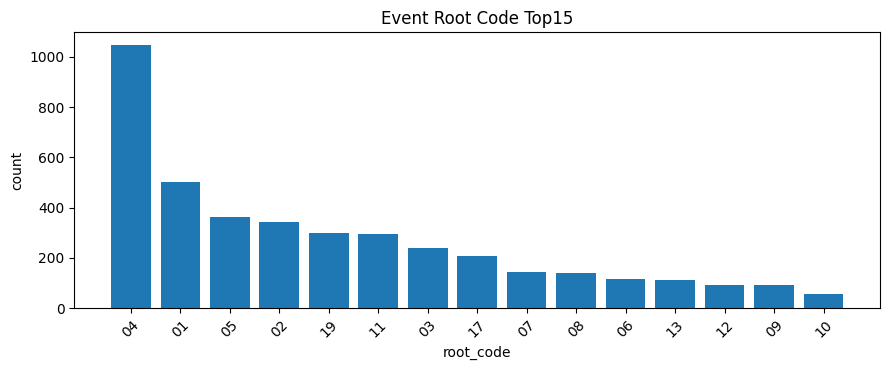

,quad_class,count
0,1,2494
1,2,493
2,3,579
3,4,611


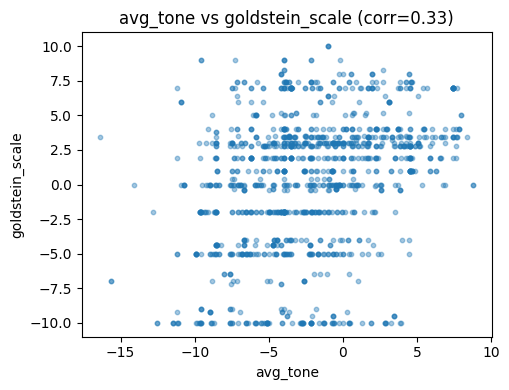

In [60]:
# Event Root Code 분포 (라벨 일부 매핑)
cameo_root = {
    "01": "Public statement",
    "02": "Appeal",
    "03": "Intent to cooperate",
    "04": "Consult",
    "05": "Diplomatic coop",
    "06": "Material coop",
    "07": "Aid",
    "08": "Yield",
    "09": "Investigate",
    "10": "Demand",
    "11": "Disapprove",
    "12": "Reject",
    "13": "Threaten",
    "14": "Protest",
    "15": "Force posture",
    "16": "Reduce relations",
    "17": "Coerce",
    "18": "Assault",
    "19": "Fight",
    "20": "Mass violence",
}
if "event_root_code" in dfe.columns:
    root_ct = (
        dfe.groupBy("event_root_code").count().orderBy(F.desc("count")).limit(15)
    ).toPandas()
    root_ct["label"] = root_ct["event_root_code"].map(cameo_root).fillna("")
    display(root_ct)

    plt.figure(figsize=(9, 3.8))
    plt.bar(root_ct["event_root_code"], root_ct["count"])
    plt.title("Event Root Code Top15")
    plt.xlabel("root_code")
    plt.ylabel("count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Quad 분포
if "quad_class" in dfe.columns:
    quad_ct = (dfe.groupBy("quad_class").count().orderBy("quad_class")).toPandas()
    display(quad_ct)

# 톤/골드스타인 관계(표본 산점 + 상관)
cols = [
    c
    for c in ["avg_tone", "goldstein_scale", "num_articles", "num_mentions"]
    if c in dfe.columns
]
samp = (
    dfe.select(*cols).dropna().sample(False, 0.3, seed=42).toPandas()
    if dfe.count() > 800
    else dfe.select(*cols).dropna().toPandas()
)
if {"avg_tone", "goldstein_scale"}.issubset(samp.columns) and len(samp) > 0:
    corr = samp[["avg_tone", "goldstein_scale"]].corr().iloc[0, 1]
    plt.figure(figsize=(5.2, 4))
    plt.scatter(samp["avg_tone"], samp["goldstein_scale"], s=10, alpha=0.4)
    plt.title(f"avg_tone vs goldstein_scale (corr={corr:.2f})")
    plt.xlabel("avg_tone")
    plt.ylabel("goldstein_scale")
    plt.tight_layout()
    plt.show()

In [70]:
# 쿼드 분포 + 쿼드별 톤/골드스타인 평균
quad_stats = (
    df.groupBy("quad_class")
    .agg(
        F.count("*").alias("events"),
        F.avg("avg_tone").alias("tone_mean"),
        F.avg("goldstein_scale").alias("gold_mean"),
    )
    .orderBy("quad_class")
).toPandas()
display(quad_stats)

,quad_class,events,tone_mean,gold_mean
0,1,2494,-1.123196,2.492181
1,2,493,-2.154684,5.160649
2,3,579,-4.383184,-3.426598
3,4,611,-4.618037,-8.015876


In [ ]:
# 쿼드별 상관계수(표본)
import pandas as pd

cols = ["quad_class", "avg_tone", "goldstein_scale", "num_articles"]
samp_pdf = (
    df.select(*cols).dropna().sample(False, 0.4, seed=42).toPandas()
    if df.count() > 1200
    else df.select(*cols).dropna().toPandas()
)


def corr_by_group(pdf, key):
    out = []
    for k, g in pdf.groupby(key):
        if len(g) >= 30:
            out.append(
                {"quad_class": k, "pearson_r": g["avg_tone"].corr(g["goldstein_scale"])}
            )
    return pd.DataFrame(out).sort_values("quad_class")


display(corr_by_group(samp_pdf, "quad_class"))

,quad_class,pearson_r
0,1,0.245612
1,2,0.125654
2,3,-0.035730
3,4,-0.049380


In [71]:
# “기사 수 가중” 상관계수(전체)
import numpy as np

g = samp_pdf.copy()
w = np.clip(g["num_articles"].fillna(1).values, 1, None)
x = g["avg_tone"].values
y = g["goldstein_scale"].values

mx = np.average(x, weights=w)
my = np.average(y, weights=w)
cov = np.average((x - mx) * (y - my), weights=w)
vx = np.average((x - mx) ** 2, weights=w)
vy = np.average((y - my) ** 2, weights=w)
w_corr = cov / np.sqrt(vx * vy)
print(f"[weighted corr by num_articles] r_w = {w_corr:.2f}")

[weighted corr by num_articles] r_w = 0.33


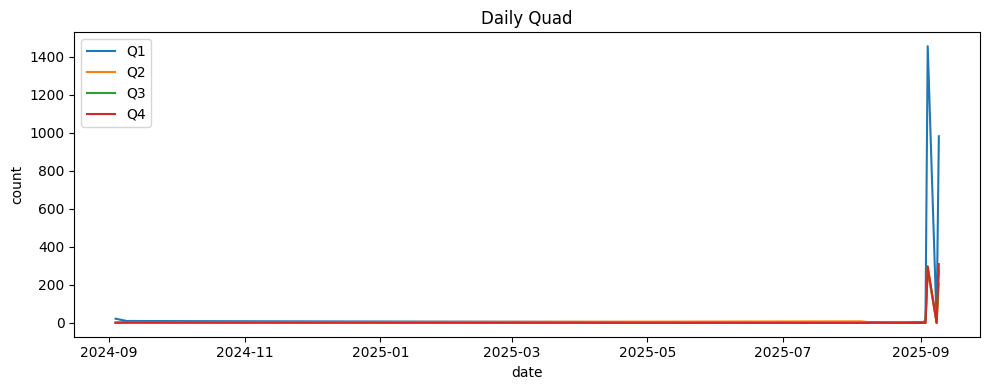

In [73]:
ts_quad = (
    df.groupBy("event_date", "quad_class")
    .count()
    .groupBy("event_date")
    .pivot("quad_class", [1, 2, 3, 4])
    .sum("count")
    .na.fill(0)
    .orderBy("event_date")
).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for c in ["1", "2", "3", "4"]:
    if c in ts_quad.columns:
        plt.plot(ts_quad["event_date"], ts_quad[c], label=f"Q{c}")
plt.title("Daily Quad")
plt.xlabel("date")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

 📌 **Event Root Code Top15**

- `04 (Consult)`가 **가장 많음**, 그 외 `01 (Public statement)`, `05 (Diplomatic coop)`, `02 (Appeal)` 순.
- **협력/발언 중심 이벤트** 비중이 높고, 갈등 계열(14~20)은 상대적으로 적음.
- → **저강도 상호작용이 중심인 데이터** 특성 반영됨.

---
📌 **`avg_tone` ↔ `goldstein_scale` 상관 분석**

- 상관 계수 `r ≈ 0.33` → **양(+)의 느슨한 상관 관계**
- **avg_tone이 높을수록 goldstein_scale도 증가하는 경향**
- 단, **산점도 상 분산이 큼** → 쿼드별 또는 기사 수 가중치 적용한 추가 분석 필요

---

### D) 소스 품질/분포(어느 파일/도메인에서 많이 왔는지)

In [61]:
# source_file 상위
if "source_file" in dfe.columns:
    sf = (
        dfe.groupBy("source_file").count().orderBy(F.desc("count")).limit(10)
    ).toPandas()
    print("[source_file Top10]")
    display(sf)

# source_url 도메인 상위 (간단 파싱)
from pyspark.sql import functions as F
from pyspark.sql import types as T


def extract_domain(url):
    try:
        from urllib.parse import urlparse

        netloc = urlparse(url).netloc
        # www 제거
        return netloc[4:] if netloc.startswith("www.") else netloc
    except Exception:
        return None


udf_domain = F.udf(extract_domain, T.StringType())
if "source_url" in dfe.columns:
    dom = (
        dfe.withColumn("domain", udf_domain("source_url"))
        .groupBy("domain")
        .count()
        .orderBy(F.desc("count"))
        .limit(20)
    ).toPandas()
    print("[source domain Top20]")
    display(dom)

[source_file Top10]


,source_file,count
0,20250904073000.export.CSV,2368
1,20250909001500.export.CSV,1809


[source domain Top20]


,domain,count
0,,4032
1,None,145


-----------------------------------------------------------

📌 **Source 품질/분포 분석**

▶️ **Top 10 source_file**
| source_file               | count |
|---------------------------|------:|
| `20250904073000.export.CSV` | 2368 |
| `20250909001500.export.CSV` | 1809 |
**두개의 파일 데이터 집중** → 임시 테스트기 때문에 

▶️ **Top 20 도메인 추출 실패**


### E) 지리 필드 품질 리포트(현재 이슈 요약)

In [62]:
geo_sum = dfe.select(
    F.avg(
        F.when(F.col("action_geo_country_code").rlike("^[A-Z]{2}$"), 1).otherwise(0)
    ).alias("fips2_ratio"),
    F.avg(
        F.when(F.col("action_geo_country_code").rlike("^[0-9]+$"), 1).otherwise(0)
    ).alias("numeric_ratio"),
    F.avg(
        F.when(
            F.col("action_geo_lat").isNotNull() & F.col("action_geo_long").isNotNull(),
            1,
        ).otherwise(0)
    ).alias("latlong_cov"),
).toPandas()
print("[ActionGeo 품질 요약]")
display(geo_sum)

[ActionGeo 품질 요약]


,fips2_ratio,numeric_ratio,latlong_cov
0,0.0,1.0,0.0


📌 ActionGeo 국가 코드 (`action_geo_country_code`)
- **FIPS 2자리 코드 비율 (`fips2_ratio`)**: `0.0`
  - 2자리 영문 국가 코드(FIPS)는 **전혀 존재하지 않음**.
- **숫자 코드 비율 (`numeric_ratio`)**: `1.0`
  - 100% 숫자 코드로만 구성됨 → **표준 국가코드 체계(FIPS/ISO)가 아님**.

**해석**: `action_geo_country_code`는 국가를 직접적으로 식별할 수 있는 코드가 아니며, **내부 식별자 또는 매핑 테이블 기반 처리**가 필요함.
